In [1]:
!pip install -U jaxlib -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jax -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability==0.17
!pip install git+https://github.com/blackjax-devs/blackjax.git
!apt update
!apt install -y graphviz
!pip install graphviz
!pip install gplearn
!pip install optuna

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.9/155.9 MB 12.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn82
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.4.1-py3-none-any.whl size=1332463 sha256=4bbcbcce00b1b15b547e8d11d456428abd3490a25136ad8f741c9257140b5a2c
  Stored in directory: /root/.cache/pip/wheels/bb/f7/56/3b5d10a573be427643de12e27ff806d622d843a5d30b0cc164
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
   

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
SERVER = 1

if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
import jax
import haiku as hk
import numpy as np
import optax
from nn_util import *
from optim_util import *
plt.style.use('ggplot')
%load_ext autoreload

In [3]:
jax.default_backend()

'gpu'

In [4]:
if SERVER:
    data_dir = "."
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

### GDSC Cell Line

In [5]:
gdsc_dir = f"{data_dir}/cell_line/gdsc2"
gdsc_exp_data = pd.read_csv(f"{gdsc_dir}/gdsc_gene_expr.csv", index_col="model_id")
gdsc_response_data = pd.read_csv(f"{gdsc_dir}/GDSC2_fitted_dose_response_24Jul22.csv", index_col="SANGER_MODEL_ID")

#### Bortezomib

In [6]:
bortezomib_response = gdsc_response_data[gdsc_response_data["DRUG_NAME"] == "Bortezomib"]
gdsc_exp_bortezomib_data = pd.merge(gdsc_exp_data, bortezomib_response["LN_IC50"], left_index=True, right_index=True)
gdsc_exp_bortezomib_data.shape

(406, 37264)

In [7]:
X, target = gdsc_exp_bortezomib_data.iloc[:,:-1], gdsc_exp_bortezomib_data.iloc[:,-1]
# change to -log10(IC_50) to make it comparable
target = -np.log10(np.exp(target)) # exp b/c the values are natural logs of raw IC_50
cancer_driver_genes_df = pd.read_csv(f"{data_dir}/cell_line/driver_genes_20221018.csv")

In [8]:
cols = X.columns.to_list()
driver_syms = cancer_driver_genes_df["symbol"].to_list()
driver_sym_list = [sym.strip() for sym in cols if sym in driver_syms]

In [9]:
X_selected = X[driver_sym_list]
X_selected.shape

(406, 768)

#### Data Preprocessing

In [10]:
seed = 196
X_train_outer_df, X_test_df, y_train_outer_df, y_test_df = train_test_split(X_selected, target, random_state=seed, shuffle=True, test_size=0.2)

In [11]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler, Normalizer, StandardScaler

train_transformer = QuantileTransformer(random_state=seed).fit(X_train_outer_df)
# train_transformer = PowerTransformer().fit(X_train_df)
train_transformed = train_transformer.transform(X_train_outer_df)
test_transformed = train_transformer.transform(X_test_df)

X_train_outer_df = pd.DataFrame(train_transformed, columns=X_train_outer_df.columns)
X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (324). n_quantiles is set to n_samples.
  warnings.warn(


In [12]:
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_outer_df, y_train_outer_df, shuffle=True,
                                                              random_state=seed, test_size=0.2)
train_indices, val_indices = X_train_df.index.to_list(), X_val_df.index.to_list()

In [13]:
X_train_outer, y_train_outer = X_train_outer_df.values, y_train_outer_df.values
X_train, y_train = jax.device_put(X_train_df.values), jax.device_put(y_train_df.values)
X_val, y_val = jax.device_put(X_val_df.values), jax.device_put(y_val_df.values)
X_test, y_test = X_test_df.values, y_test_df.values

#### NAM Model

In [14]:
from typing import NamedTuple

class TrainingState(NamedTuple):
    params: hk.Params
    avg_params: hk.Params
    opt_state: optax.OptState

def exu(x, weight, bias):
    """ExU hidden unit modification."""
    return relu_n((x - bias) @ jnp.exp(weight))


# Activation Functions
def relu(x, weight, bias):
    """ReLU activation."""
    return jax.nn.relu((x - bias) @ weight)


def relu_n(x, n = 1):
    """ReLU activation clipped at n."""
    return jnp.clip(x, 0, n)


class FeatureNet(hk.Module):
    """Neural Network model for each individual feature.
    Attributes:
      hidden_layers: A list containing hidden layers. The first layer is an
        `ActivationLayer` containing `num_units` neurons with specified
        `activation`. If `shallow` is False, then it additionally contains 2
        tf.keras.layers.Dense ReLU layers with 64, 32 hidden units respectively.
      linear: Fully connected layer.
    """

    def __init__(self,
                 input_shape,
                 num_units,
                 dropout = 0.5,
                 shallow = True,
                 feature_num = 0,
                 activation = 'exu',
                 name=None):
        """Initializes FeatureNN hyperparameters.
        Args:
          num_units: Number of hidden units in first hidden layer.
          dropout: Coefficient for dropout regularization.
          shallow: If True, then a shallow network with a single hidden layer is
            created, otherwise, a network with 3 hidden layers is created.
          feature_num: Feature Index used for naming the hidden layers.
          activation: Activation and type of hidden unit(ExUs/Standard) used in the
            first hidden layer.
        """


        # if name is not None:
        super().__init__(name)
        # else:
        #     super().__init__(f"f_{feature_num}")
        self._input_shape = input_shape
        self._num_units = num_units
        self._dropout = dropout
        self._feature_num = feature_num
        self._shallow = shallow

        self._activation = activation

        if activation == "exu":
            self._act_fn = exu
            self._initializer = hk.initializers.TruncatedNormal(mean=4, stddev=0.5)

        else:
            self._act_fn = relu
            self._initializer = hk.initializers.UniformScaling()


    def __call__(self, x, is_training):
        key = hk.next_rng_key()
        k1, k2 = jax.random.split(key, 2)
        w = hk.get_parameter("w", [self._input_shape, self._num_units], init=self._initializer)
        c = hk.get_parameter("c", [self._input_shape], init=hk.initializers.TruncatedNormal(stddev=0.5))
        # x = relu_n(self._act_fn(x, w, b), 1)
        x = self._act_fn(x[...,None], w, c)
        if not self._shallow:
            x = hk.Linear(64, w_init=hk.initializers.UniformScaling())(x)
            x = jax.nn.relu(x)
            if is_training:
                x = hk.dropout(k1, self._dropout, x)
            x = hk.Linear(32, w_init=hk.initializers.UniformScaling())(x)
            x = jax.nn.relu(x)
            if is_training:
                x = hk.dropout(k2, self._dropout, x)


        x = hk.Linear(1, with_bias=False, w_init=hk.initializers.UniformScaling())(x)

        return x

class NAM:
    """Neural additive model.
    Attributes:
      feature_nns: List of FeatureNN, one per input feature.
    """
    def __init__(self, *,
                 num_inputs,
                 num_units,
                 step_size_fn,
                 loss_fn,
                 shallow = True,
                 feature_dropout = 0.0,
                 dropout = 0.0,
                 output_reg = 0.0,
                 l2_reg = 0.0,
                 activation="exu"):

        """Initializes NAM hyperparameters.
        Args:
          num_units: Number of hidden units in first layer of each feature net.
          trainable: Whether the NAM parameters are trainable or not.
          shallow: If True, then shallow feature nets with a single hidden layer are
            created, otherwise, feature nets with 3 hidden layers are created.
          feature_dropout: Coefficient for dropping out entire Feature NNs.
          dropout: Coefficient for dropout within each Feature NNs.
          **kwargs: Arbitrary keyword arguments. Used for passing the `activation`
            function as well as the `name_scope`.
        """

        self._num_inputs = num_inputs
        self._shallow = shallow
        self._feature_dropout = feature_dropout
        self._dropout = dropout
        self.loss_fn = loss_fn
        self._activation = activation
        self.output_reg = output_reg
        self.l2_reg = l2_reg
        # if isinstance(num_units, list):
        #     assert len(num_units) == num_inputs
        #     self._num_units = num_units
        # elif isinstance(num_units, int):
        #     self._num_units = [num_units for _ in range(self._num_inputs)]

        self._num_units = num_units
        self.optimiser = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(step_size_fn), optax.scale(-1.0))

        self._forward = hk.transform(self._forward_fn)
        # self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

    def init(self, key, x):
        params = self._forward.init(key, x, True)
        opt_state = self.optimiser.init(params)
        return TrainingState(params, params, opt_state)

    def apply(self, params, key, x, is_training=True):
        pred, per_feat_pred =  self._forward.apply(params, key, x, is_training)
        return pred, per_feat_pred

    def update(self, state, key, x, y):
        grads, per_feat_pred = jax.grad(self.loss, has_aux=True)(state.params, key, x, y, True)
        updates, opt_state = self.optimiser.update(grads, state.opt_state)
        params = optax.apply_updates(state.params, updates)

        avg_params = optax.incremental_update(params, state.avg_params, step_size=1e-3)
        return TrainingState(params, avg_params, opt_state), per_feat_pred


    def loss(self, params, key, x, y, is_training):
        preds, per_feat_pred = self.apply(params, key, x, is_training)
        loss = self.loss_fn(preds, y)
        reg_loss = 0.0

        per_feature_norm = [jnp.mean(jnp.square(outputs)) for outputs in per_feat_pred]
        per_feature_norm = sum(per_feature_norm) / len(per_feature_norm)
        l2_features = self.output_reg*per_feature_norm
        reg_loss += l2_features

        l2_per_coef = 0.5 * sum(
            jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params)) / len(per_feat_pred)

        reg_loss += self.l2_reg*l2_per_coef

        return loss + reg_loss, per_feat_pred

    def _forward_fn(self, x, is_training):
        key = hk.next_rng_key()
        x = jnp.array(jnp.split(x, self._num_inputs, axis=-1)).squeeze()
        # per_feat_out = []
        # for i in range(self._num_inputs):
        #     per_feat_out.append(FeatureNet(1, self._num_units[i], self._dropout, self._shallow, i, self._activation)(x[i], is_training).squeeze())
        per_feat_out = jax.vmap(lambda i, f: FeatureNet(1, self._num_units, self._dropout, self._shallow, i, self._activation)(f, is_training).squeeze())(jnp.arange(self._num_inputs), x)
        if is_training:
            mask = jax.random.bernoulli(key, 1 - self._feature_dropout, shape=(self._num_inputs,))

            out = jnp.sum(per_feat_out.T @ jnp.diag(mask), axis=1)
        else:
            out = jnp.sum(per_feat_out, axis=0)

        b = hk.get_parameter("b", [1,], init=hk.initializers.Constant(0))

        return out + b, per_feat_out

In [15]:
import torch
from tqdm import tqdm

def mse_loss(preds, target):
    return jnp.mean((preds - target)**2)

def reg_eval(params, model, rng, x, y):
    preds, _ = model.apply(params, rng, x, False)
    return jnp.sqrt(mse_loss(preds, y))



def train_loop(seed, train_loader, x_val, y_val,
               epochs, output_reg, dropout, schedule_fn,
               l2_reg=0.0, feature_dropout=0.0,  num_units = 64,
               activation = 'relu',
               eval_epoch=50, shallow=True):

    key = jax.random.PRNGKey(seed)

    loss_fn = mse_loss
    eval_fn = reg_eval

    # num_unique_vals = [
    #     len(jnp.unique(x_train[:, i])) for i in range(x_train.shape[1])
    # ]
    # num_units = [
    #     min(num_basis_functions, i * units_multiplier) for i in num_unique_vals
    # ]

    model = NAM(num_inputs=x_val.shape[-1] ,num_units=num_units,
                step_size_fn=schedule_fn,
                dropout=jnp.float32(dropout),
                feature_dropout=jnp.float32(feature_dropout),
                activation=activation,
                shallow=shallow,
                output_reg=output_reg,
                l2_reg=l2_reg, loss_fn=loss_fn)

    state = model.init(key, next(iter(train_loader))[0])

    val_losses = []
    pgbar = tqdm(range(epochs))
    best_pram = None
    lst_loss = 1e9
    patience = 0
    for epoch in pgbar:
        for x, y in train_loader:
            _, key = jax.random.split(key, 2)
            state, _ = model.update(state, key, x, y)
            # print(state.avg_params)

        if epoch % eval_epoch == 0:
            loss = eval_fn(state.params, model, key, x_val, y_val)
            if epoch != 0:
                if loss > val_losses[-1]:
                    patience += 1
                else:
                    if loss < lst_loss:
                        lst_loss = loss
                        best_pram = state.params

            if patience > 30:
                break

            val_losses.append(loss)

            pgbar.set_postfix({"va_loss": loss, "patience": patience})

    return model, best_pram, val_losses

In [16]:
lr_0 = 1e-3
l2_reg, out_reg = 1e-6, 0.0
batch_size = 128
epochs = 500
rng_key = jax.random.PRNGKey(seed)
torch.manual_seed(seed)
data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=False)
total_steps = epochs*len(data_loader)
schedule_fn = lambda t: lr_0
# schedule_fn = optax.cosine_decay_schedule(lr_0, total_steps)
model, params, val_loss = train_loop(seed, data_loader, X_val, y_val, epochs,
                                    out_reg, 0.2, schedule_fn, l2_reg, shallow=True,
                                    activation="exu", eval_epoch=50, num_units=64, feature_dropout=0.0)

 10%|▉         | 49/500 [01:53<17:21,  2.31s/it, va_loss=128.06178, patience=0]  


KeyboardInterrupt: 

In [ ]:
test_loss = reg_eval(params, model, rng_key, X_test, y_test)
test_loss

In [ ]:
from sklearn.metrics import r2_score
y_test_pred, per_feat_pred = model.apply(params, rng_key, X_test, False)
r2_score(y_test, y_test_pred)

In [ ]:
np.sort(np.mean(per_feat_pred, axis=-1))[::-1][:50]

In [92]:
def compute_mean_feature_importance(model, params, key, x, cols):
    _, per_feat_preds = model.apply(params,key, x, False)
    feature_predictions = np.array(per_feat_preds)
    mean_feat_preds = np.mean(feature_predictions, axis=-1)

    feat_importance = {}
    feat_scores = np.zeros(len(cols))
    for i, col in enumerate(cols):
        mean_pred = mean_feat_preds[i]
        feat_preds = feature_predictions[i]
        mean_abs_score = np.mean(np.abs(feat_preds - mean_pred[...,None]), axis=-1)
        feat_scores[i] = mean_abs_score
        feat_importance[col] = mean_abs_score

    return feat_importance, feat_scores

def plot_mean_feature_importance(feat_importance, cols, width = 0.3, name="GDSC"):
    x1, x2 = zip(*feat_importance.items())
    fig, ax = plt.subplots(figsize=(5, 4))
    ind = np.arange(len(x1))  # the x locations for the groups
    x1_indices = np.argsort(x2)
    cols_here = [cols[i] for i in x1_indices]
    x2_here = [x2[i] for i in x1_indices]

    ax.bar(ind, x2_here, width, label='NAMs')
    ax.set_xticks(ind + width/2, cols_here, rotation=90, fontsize='large')
    ax.set_ylabel('Mean Absolute Score', fontsize='x-large')
    ax.legend(loc='upper left', fontsize='large')
    ax.set_title(f'Overall Importance: {name}', fontsize='x-large')

In [93]:
cols = X_train_outer_df.columns.to_list()
feature_importance_dict, feat_scores = compute_mean_feature_importance(model, params, rng_key, X_test, cols)

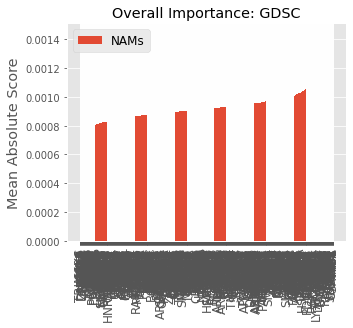

In [82]:
plot_mean_feature_importance(feature_importance_dict, cols)

In [94]:
feat_scores

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [95]:
idxs = np.argsort(np.mean(per_feat_pred, axis=-1)).squeeze()[::-1][:10]

In [96]:
mask = np.zeros(X_test.shape[-1])
mask[idxs] = 1.0
X_test_mask = X_test @ np.diag(mask)

In [97]:
reg_eval(params, model, rng_key, X_test_mask, y_test)

Array(0.36981997, dtype=float32)

In [98]:
X_train_outer_df.iloc[:,idxs].columns.to_list()

['ZXDB',
 'ZRSR2',
 'ZNRF3',
 'ZNF814',
 'ZNF780A',
 'ZNF721',
 'ZNF680',
 'ZNF626',
 'ZNF521',
 'ZNF429']